# Forecasting Demo 1: Prophet and NeuralProphet

This notebook is the first of a series that introduces the application of popular, recently developed time series forecasting methods. In particular, we emphasize the use of consistent evaluation metrics and analysis across all models and model configurations. 

Use these notebooks as tools to explore the application of various forecasting methods to multivariate time series datasets, and to inspire an experimental approach for comparing multiple models and model configurations.

This notebook explores the application of **Prophet** and **NeuralProphet** to exchange rate forecasting.

In [ ]:
if 'google.colab' in str(get_ipython()):
    !pip install prophet
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prophet import Prophet
from neuralprophet import NeuralProphet

# Data Loading

### Load exchange rate data file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data_filename = "/h/ethanj/bootcamp_datasets/exchange_rate/exchange_rate.csv"
data_filename = "/content/drive/MyDrive/bootcamp_datasets/exchange_rate/exchange_rate.csv"
data_df = pd.read_csv(data_filename)
data_df['date'] = pd.to_datetime(data_df['date'])
data_df

,date,0,1,2,3,4,5,6,OT
0,1990-01-01,0.785500,1.611000,0.861698,0.634196,0.211242,0.006838,0.525486,0.593000
1,1990-01-02,0.781800,1.610000,0.861104,0.633513,0.211242,0.006863,0.523972,0.594000
2,1990-01-03,0.786700,1.629300,0.861030,0.648508,0.211242,0.006975,0.526316,0.597300
3,1990-01-04,0.786000,1.637000,0.862069,0.650618,0.211242,0.006953,0.523834,0.597000
4,1990-01-05,0.784900,1.653000,0.861995,0.656254,0.211242,0.006940,0.527426,0.598500
...,...,...,...,...,...,...,...,...,...
7583,2010-10-06,0.718494,1.222195,0.737485,0.969974,0.143697,0.008500,0.688565,0.690846
7584,2010-10-07,0.721839,1.223459,0.741155,0.977297,0.143763,0.008595,0.690288,0.695701
7585,2010-10-08,0.723197,1.234111,0.745184,0.984446,0.143997,0.008562,0.691419,0.695943
7586,2010-10-09,0.720825,1.233905,0.744131,0.980344,0.143993,0.008555,0.690942,0.692689


### Split data according to use case

For simplicity, this notebook uses only one validation period consisting of the last `test_lead_time` rows in the dataset. Other notebooks give examples of rolling cross validation using multiple validation periods given by a set of cutoff dates. 

The purpose of this notebook is to explore a simpler problem formulation using multiple models. The experiments and analysis can be easily generalized for rolling cross validation.

In [ ]:
test_lead_time = 365
train_df = data_df.iloc[:-test_lead_time]
test_df = data_df.iloc[-test_lead_time:]

In [ ]:
train_df

,date,0,1,2,3,4,5,6,OT
0,1990-01-01,0.785500,1.611000,0.861698,0.634196,0.211242,0.006838,0.525486,0.593000
1,1990-01-02,0.781800,1.610000,0.861104,0.633513,0.211242,0.006863,0.523972,0.594000
2,1990-01-03,0.786700,1.629300,0.861030,0.648508,0.211242,0.006975,0.526316,0.597300
3,1990-01-04,0.786000,1.637000,0.862069,0.650618,0.211242,0.006953,0.523834,0.597000
4,1990-01-05,0.784900,1.653000,0.861995,0.656254,0.211242,0.006940,0.527426,0.598500
...,...,...,...,...,...,...,...,...,...
7218,2009-10-06,0.726111,1.488317,0.720189,1.012417,0.154114,0.008312,0.710182,0.685096
7219,2009-10-07,0.729235,1.480166,0.721917,1.007765,0.154207,0.008303,0.707772,0.687238
7220,2009-10-08,0.728412,1.483459,0.720106,1.011260,0.154055,0.008294,0.706317,0.683644
7221,2009-10-09,0.728306,1.473839,0.721709,0.998707,0.153995,0.008316,0.704493,0.684018


In [ ]:
test_df

,date,0,1,2,3,4,5,6,OT
7223,2009-10-11,0.728491,1.474448,0.721813,0.999001,0.153995,0.008315,0.704493,0.684252
7224,2009-10-12,0.728491,1.474448,0.721813,0.999001,0.153995,0.008315,0.704493,0.684252
7225,2009-10-13,0.716281,1.468321,0.716145,0.995124,0.153013,0.008380,0.700827,0.673197
7226,2009-10-14,0.714847,1.466706,0.714921,0.990251,0.153315,0.008404,0.700329,0.669860
7227,2009-10-15,0.706964,1.462202,0.710043,0.991616,0.152516,0.008433,0.696330,0.663812
...,...,...,...,...,...,...,...,...,...
7583,2010-10-06,0.718494,1.222195,0.737485,0.969974,0.143697,0.008500,0.688565,0.690846
7584,2010-10-07,0.721839,1.223459,0.741155,0.977297,0.143763,0.008595,0.690288,0.695701
7585,2010-10-08,0.723197,1.234111,0.745184,0.984446,0.143997,0.008562,0.691419,0.695943
7586,2010-10-09,0.720825,1.233905,0.744131,0.980344,0.143993,0.008555,0.690942,0.692689


# Prophet

Univariate forecasting that supports additional *future* regressors. Prophet does not support the inclusion of *lagged regressors*, i.e. it does not support the use of historical values of multiple series to predict a single target series. We include it as a baseline because it is popular, lightweight, interpretable, and performs very well in some domains. 

Prophet is based on a Generalized Additive Model (GAM):

<center>$ y(t) = g(t) + s(t) + h(t) + \epsilon_t$</center>

where $y(t)$ is the target series, $g(t)$ is the trend function, $s(t)$ is the seasonality or periodic function, $h(t)$ is a function reflecting holidays or other irregular events, and $\epsilon_t$ is an error term that is assumed to be normally distributed.

Despite being formulated as an additive model, multiplicative interaction between seasonality and trend components is supported (using a log transform). In the implementation, this is easily configurable using a constructor paramter. See the [documentation](https://facebook.github.io/prophet/docs/multiplicative_seasonality.html) for more details.

#### Data Preparation

Prophet, like most forecasting packages, imposes its own, specific format for input data. It expects inputs in the form of a Pandas DataFrame with two columns, `ds` and `y`, which correspond to Pandas-formatted timestamps and the target time series, respectively.

In this example, we create a Prophet DataFrame by selecting the columns `date` and `OT` from the exchange rate dataset (the name `OT` stands for "Our Target" as described in the [Autoformer paper](https://arxiv.org/abs/2106.13008)'s benchmark datasets). We then rename those columns to `ds` and `y`, respectively. 

Note that the `ds` column is already correctly formatted using the Pandas datetime format, since we converted it immediately after loading the data. When reading CSVs, always be sure to check that datestamps are properly formatted.

In [ ]:
prophet_train_df = train_df[['date', 'OT']]
prophet_train_df = prophet_train_df.rename({'date':'ds', 'OT':'y'}, axis=1)
prophet_train_df

,ds,y
0,1990-01-01,0.593000
1,1990-01-02,0.594000
2,1990-01-03,0.597300
3,1990-01-04,0.597000
4,1990-01-05,0.598500
...,...,...
7218,2009-10-06,0.685096
7219,2009-10-07,0.687238
7220,2009-10-08,0.683644
7221,2009-10-09,0.684018


#### Model Initialization

In [ ]:
model = Prophet()
model = model.fit(prophet_train_df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Produce Forecast

To produce a forecast using a fitted Prophet model, you need to pass it a dataframe with the desired timestamps in a column named `ds`. In the example below, we use the fitted model object to produce a dataframe `future` with dates that extend 365 days beyond the training dates. Passing `future` to the fitted model's `predict` function will return a dataframe populated with a detailed forecast, including model component values and confidence ranges. 

In [ ]:
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

In [ ]:
forecast.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
7583,2010-10-06,0.699386,0.578981,0.811452,0.590071,0.796613,0.000306,0.000306,0.000306,-0.000088,-0.000088,-0.000088,0.000394,0.000394,0.000394,0.0,0.0,0.0,0.699692
7584,2010-10-07,0.699304,0.589389,0.807311,0.589408,0.796971,0.000552,0.000552,0.000552,-0.000010,-0.000010,-0.000010,0.000562,0.000562,0.000562,0.0,0.0,0.0,0.699856
7585,2010-10-08,0.699223,0.584997,0.806877,0.588399,0.797289,0.000830,0.000830,0.000830,0.000107,0.000107,0.000107,0.000723,0.000723,0.000723,0.0,0.0,0.0,0.700053
7586,2010-10-09,0.699141,0.579027,0.804023,0.587431,0.797853,0.000978,0.000978,0.000978,0.000101,0.000101,0.000101,0.000877,0.000877,0.000877,0.0,0.0,0.0,0.700119
7587,2010-10-10,0.699059,0.586492,0.805077,0.586943,0.798411,0.000997,0.000997,0.000997,-0.000026,-0.000026,-0.000026,0.001023,0.001023,0.001023,0.0,0.0,0.0,0.700056


### Plotting the Forecast

The following code visualizes the application of the fitted Prophet model to both in-sample (training) and out-of-sample (testing) data. Visualization and evaluation of forecasting models using out-of-sample data is crucial for estimating future performance. Notice again that here we are only considering **one** period for out-of-sample performance visualization. Rolling cross validation, where many sequential periods are used for out-of-sample evaluation, is considered in another notebook.

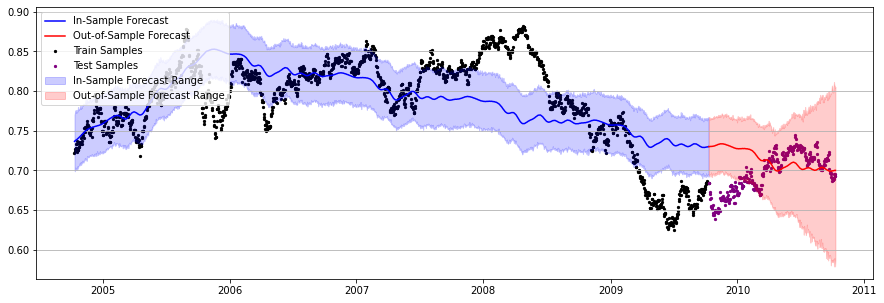

In [43]:
lag_time = 5*365

fig, ax = plt.subplots(figsize=(15, 5))

ax.scatter(train_df.date[-lag_time:], train_df.OT[-lag_time:], color='black', s=5, label='Train Samples')
ax.scatter(test_df.date, test_df.OT, color='purple', s=5, label='Test Samples')

ax.plot(forecast.ds.iloc[-lag_time-test_lead_time:-test_lead_time], 
        forecast.yhat.iloc[-lag_time-test_lead_time:-test_lead_time], color='blue', label='In-Sample Forecast')

ax.fill_between(forecast.ds.iloc[-lag_time-test_lead_time:-test_lead_time], 
    forecast.yhat_lower.iloc[-lag_time-test_lead_time:-test_lead_time], 
    forecast.yhat_upper.iloc[-lag_time-test_lead_time:-test_lead_time],
    color='blue', label='In-Sample Forecast Range', alpha=0.2)

ax.plot(forecast.ds.iloc[-test_lead_time:], forecast.yhat.iloc[-test_lead_time:], 
        color='red', label='Out-of-Sample Forecast')

ax.fill_between(forecast.ds.iloc[-test_lead_time:], 
    forecast.yhat_lower.iloc[-test_lead_time:], 
    forecast.yhat_upper.iloc[-test_lead_time:],
    color='red', label='Out-of-Sample Forecast Range', alpha=0.2)

ax.legend(loc='upper left')
ax.grid(axis='y')

### Evaluation Metrics

In order to objectively compare the performance of this and other models on out-of-sample forecasting performance, we will need to collect output in a consistent format and apply a suite of standard evaluation metrics:

- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- Mean Absolute Error (MAE)
- Mean Absolute Percentage Error (MAPE)

See the article [Time Series Forecast Error Metrics You Should Know](https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27) for an overview of these and other popular forecasting error metrics. 


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

metrics = {
    'mse': mean_squared_error,
    'rmse': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    'mae': mean_absolute_error,
    'mape': mean_absolute_percentage_error
}

Before applying these metrics, we will start to collect the out-of-sample forecasts produced by the Prophet model together with the ground truth time series. We aim to do this so that it will be easy to incorporate forecasts produced by (possibly many) other models or model configurations. Be sure to use a naming scheme for columns that is easy to parse.

Note that in the code below we are collecting the forecast ranges (`yhat_lower` and `yhat_upper`) but not using them directly in this evaluation. Since we may want to examine these ranges in other analyses, we will collect them into `results_df` here and save them to file later.

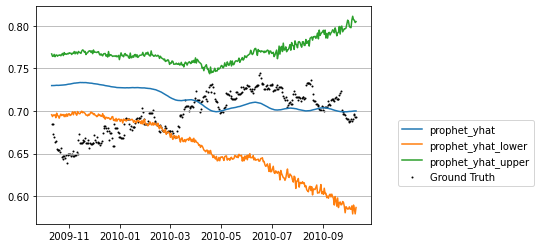

In [71]:
results_df = pd.DataFrame({'ground_truth': test_df.OT.values}, index=test_df.date)
results_df['prophet_yhat'] = forecast.loc[forecast.ds.isin(test_df.date)].yhat.values
results_df['prophet_yhat_lower'] = forecast.loc[forecast.ds.isin(test_df.date)].yhat_lower.values
results_df['prophet_yhat_upper'] = forecast.loc[forecast.ds.isin(test_df.date)].yhat_upper.values

def plot_results(results_df):
    fig, ax = plt.subplots()
    ax.scatter(results_df.index, results_df.ground_truth, s=1, color='black', label='Ground Truth')
    for col in results_df.columns:
        if col != 'ground_truth':
            ax.plot(results_df.index, results_df[col], label=col)
    ax.grid(axis='y')
    ax.legend(bbox_to_anchor=(1.5, 0.5))

plot_results(results_df)

In [ ]:
results_df.tail(5)

,ground_truth,prophet_yhat,prophet_yhat_lower,prophet_yhat_upper
date,,,,
2010-10-06,0.690846,0.699692,0.578981,0.811452
2010-10-07,0.695701,0.699856,0.589389,0.807311
2010-10-08,0.695943,0.700053,0.584997,0.806877
2010-10-09,0.692689,0.700119,0.579027,0.804023
2010-10-10,0.692689,0.700056,0.586492,0.805077


Now that we have collected the out-of-sample Prophet forecast and ground truth time series into `results_df`, we iteratively apply the evaluation metrics and collect the results.

In [74]:
def apply_eval_metrics(results_df, eval_columns, metrics):
    eval_results = {}

    for forecast_name in eval_columns:
        eval_results[forecast_name] = {}
        for metric_name, metric_fn in metrics.items():
            eval_results[forecast_name][metric_name] = metric_fn(results_df['ground_truth'], 
                                                                results_df[forecast_name])
    return pd.DataFrame(eval_results).T.sort_values('mape')
    
eval_columns = ['prophet_yhat']  # Select which columns from results_df to evaluate.
apply_eval_metrics(results_df, eval_columns, metrics)

,mae,mape,mse,rmse
prophet_yhat,0.031331,0.046022,0.001564,0.039554


Now that we have collected baseline evaluation metrics for the Prophet model aplied to our out-of-sample data, we can begin to experiment with other configurations or models. Next, let's explore the NeuralProphet model.

# NeuralProphet

Let's proceed to explore the [NeuralProphet](https://neuralprophet.com/html/index.html) model. Please review the following resources to learn more:

- [Paper](https://arxiv.org/abs/2111.15397)
- [Documentation](https://neuralprophet.com/html/contents.html)
- [GitHub](https://github.com/ourownstory/neural_prophet)

In the words of its developers, NeuralProphet is "*based on neural networks, inspired by Facebook Prophet and AR-Net, built on PyTorch*". A very important differentiating feature is that NeuralProphet conveniently supports *lagged regressors*. In the context of this running example, NeuralProphet supports the use of multiple other currencies' time series. With this expanded flexibility, however, the model is more complex, with a greater number of design choices and hyperparameters to consider. 

The official [documentation on lagged regressors (lagged covariates)](https://neuralprophet.com/html/lagged_covariates_energy_ercot.html) gives several examples for configuring NeuralProphet models to use lagged regressors, but commentary and suggestions on best practices are largely absent. 

In the following code, we will consider a small number of NeuralProphet model configurations applied to the same forecasting task from above. Importantly, we retain the same train/test (in-sample/out-of-sample) split, and we will apply the same evaluation metrics to NeuralProphet's forecasts. 

### Baseline/Default Model

A baseline NeuralProphet model with lagged regressors using default initialization parameters, except:

- `n_lags=365`, specifying that the autoregressive component of the model should use the past 365 daily observations as inputs
- `n_forecasts=365`, specifying that our use case is to predict the target signal 365 days into the future

In [ ]:
np_train_df = train_df.reset_index().rename({'date':'ds', 'OT':'y'}, axis=1).drop('index', axis=1)
np_test_df = test_df.reset_index().rename({'date':'ds','OT':'y'}, axis=1).drop('index', axis=1)

In [ ]:
np_model = NeuralProphet(n_lags=365, n_forecasts=365)

# Add the non-target feature columns as lagged regressors
for feature in range(7):
    np_model.add_lagged_regressor(f'{feature}')
    
np_model.fit(np_train_df, freq='D')

Like with Prophet, we can use first the NeuralProphet model object to produce a dataframe with empty future values, and then have it generate predictions.

In [ ]:
np_future_df = np_model.make_future_dataframe(np_train_df, periods=365)
np_forecast = np_model.predict(np_future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.986% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.986% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


,ds,0,1,2,3,4,5,6,y
0,2008-10-11,0.820008,1.556723,0.862199,1.012043,0.161238,0.008376,0.756853,0.784468
1,2008-10-12,0.808931,1.532743,0.848497,0.998418,0.161132,0.008298,0.751120,0.769882
2,2008-10-13,0.808931,1.532743,0.848497,0.998418,0.161132,0.008298,0.751120,0.769882
3,2008-10-14,0.809520,1.523450,0.848353,0.992093,0.160813,0.008355,0.748803,0.770268
4,2008-10-15,0.811524,1.517554,0.846736,0.993789,0.160979,0.008450,0.750413,0.779545
...,...,...,...,...,...,...,...,...,...
725,2010-10-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
726,2010-10-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
727,2010-10-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
728,2010-10-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


NeuralProphet's forecast output format is different than Prophet's. Rather than predicting a single series for `yhat`, it uses one column per future period - in this case, `yhat1` to `yhat365`. As a result, the actual forecast `yhat` is stored along the diagonal of the sub-array obtained by selecting the columns `yhat1` to `yhat365` from the `np_forecast` DataFrame. The following code performs this selection.

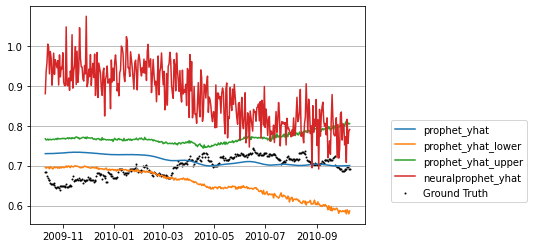

In [72]:
def yhat_from_neuralprophet_forecast(np_forecast, yhat_name):

    yhat_columns = ['ds'] + [col for col in np_forecast.columns if "yhat" in col]
    yhat_df = np_forecast.loc[np_forecast.ds.isin(test_df.date)][yhat_columns].set_index('ds')
    yhat_values = np.diag(yhat_df.values)
    return pd.Series(yhat_values, index=yhat_df.index, name=yhat_name)

results_df['neuralprophet_yhat'] = yhat_from_neuralprophet_forecast(np_forecast, 'neuralprophet_yhat')
plot_results(results_df)

In [75]:
eval_columns = ['prophet_yhat', 'neuralprophet_yhat']  # Select which columns from results_df to evaluate.
apply_eval_metrics(results_df, eval_columns, metrics)

,mse,rmse,mae,mape
prophet_yhat,0.001564,0.039554,0.031331,0.046022
neuralprophet_yhat,0.039482,0.198700,0.177064,0.257966


### Restricted model

The baseline NeuralProphet model does not perform well on out-of-sample data. We can consider multiple changes to the model's configuration and hyperparameters in pursuit of better performance. Let's consider the following configuration that restricts the model to using only the last observed value of last regressors, as opposed to `n_lags` past observations. While less expressive, this model may be less prone to overfitting.

In [ ]:
np_model_last_sample_only = NeuralProphet(n_lags=365, n_forecasts=365)

# Add the non-target feature columns as lagged regressors
for feature in range(7):
    np_model_last_sample_only.add_lagged_regressor(f'{feature}', only_last_value=True)
    
np_model_last_sample_only.fit(np_train_df, freq='D')

In [ ]:
np_future_df_last_sample_only = np_model_last_sample_only.make_future_dataframe(np_train_df, periods=365)
np_forecast_last_sample_only = np_model_last_sample_only.predict(np_future_df_last_sample_only)

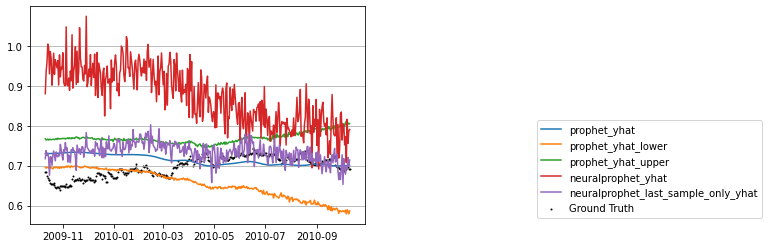

In [73]:
results_df['neuralprophet_last_sample_only_yhat'] = yhat_from_neuralprophet_forecast(np_forecast_last_sample_only, 'neuralprophet_last_sample_only_yhat')
plot_results(results_df)

In [76]:
eval_columns = ['prophet_yhat', 'neuralprophet_yhat', 'neuralprophet_last_sample_only_yhat']  # Select which columns from results_df to evaluate.
apply_eval_metrics(results_df, eval_columns, metrics)

,mse,rmse,mae,mape
prophet_yhat,0.001564,0.039554,0.031331,0.046022
neuralprophet_last_sample_only_yhat,0.002591,0.050905,0.040878,0.059973
neuralprophet_yhat,0.039482,0.198700,0.177064,0.257966


### Model with Sparse Neural Autoregression

In [ ]:
np_model_sparse_nar = NeuralProphet(n_lags=3*365, 
                                    n_forecasts=365,
                                    learning_rate=1e-2,
                                    num_hidden_layers=1,
                                    d_hidden=16,
                                    ar_sparsity=0.9
                                    )

# Add the non-target feature columns as lagged regressors
for feature in range(7):
    np_model_sparse_nar.add_lagged_regressor(f'{feature}')
    
np_model_sparse_nar.fit(np_train_df, freq='D')

In [ ]:
np_future_df_sparse_nar = np_model_sparse_nar.make_future_dataframe(np_train_df, periods=365)
np_forecast_sparse_nar = np_model_sparse_nar.predict(np_future_df_sparse_nar)
results_df['neuralprophet_sparse_nar_yhat'] = yhat_from_neuralprophet_forecast(np_forecast_sparse_nar, 'neuralprophet_sparse_nar_yhat')
plot_results(results_df)

In [83]:
eval_columns = ['prophet_yhat', 
                'neuralprophet_yhat', 
                'neuralprophet_last_sample_only_yhat',
                'neuralprophet_sparse_nar_yhat',
                ] 
apply_eval_metrics(results_df, eval_columns, metrics)

,mse,rmse,mae,mape
prophet_yhat,0.001564,0.039554,0.031331,0.046022
neuralprophet_last_sample_only_yhat,0.002591,0.050905,0.040878,0.059973
neuralprophet_sparse_nar_yhat,0.003444,0.058686,0.047001,0.069296
neuralprophet_yhat,0.039482,0.198700,0.177064,0.257966


# Reflections and Next Steps

So far, the best performing model on the exchange rates dataset is the baseline, univariate Prophet model. Using this very simple experiment using a single period for out-of-sample forecast evaluation, we have failed to find a configuration of NeuralProphet (which includes other currency values as additional covariates or features) that outperforms the univariate baseline. This reflects a common challenge in forecasting: how to incorporate additional sources of information such that they reliably improve forecasts over univariate baselines?

Of course, we have only considered a very small number of comfigurations using NeuralProphet, many more model and hyperparameter configurations are possible. Please refer to the [NeuralProphet documentation](https://neuralprophet.com/html/contents.html) for detailed information. However, to *find* a better configuration may require significant effort, either manual or automated (via a hyperparameter search, for example). In practical forecasting use cases, it may be important to consider the time, resources, and effort that are needed to find a forecasting model that is better than  baseline.

The following notebooks in this series will cover additional models (N-BEATS and DeepAR) as well as rolling cross validation using Prophet. In order to compare the out-of-sample forecasts produced by this notebook to others, the `results_df` DataFrame is saved below. Hopefully we will find a model that can outperform Prophet in our out-of-sample evaluation experiment!


In [84]:
output_filename = "/content/drive/MyDrive/bootcamp_datasets/exchange_rate/exchange_rate_results_notebook1.csv"
results_df.to_csv(output_filename)